In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

In [2]:
df = sns.load_dataset("iris")

df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
138,6.0,3.0,4.8,1.8,virginica
7,5.0,3.4,1.5,0.2,setosa
122,7.7,2.8,6.7,2.0,virginica
16,5.4,3.9,1.3,0.4,setosa
80,5.5,2.4,3.8,1.1,versicolor


We'll focus on two attributes, since we can easily visualize.

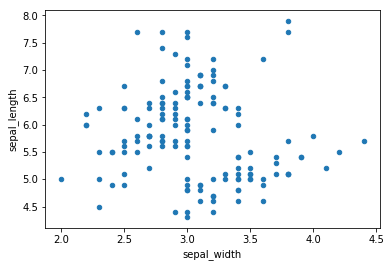

In [3]:
cols = ["sepal_width", "sepal_length"]

p = df.plot.scatter(*cols)

Let's use the number of species as the number of clusters for KMeans.

In [4]:
k = df.species.nunique()

We could also experiment with random data

In [5]:
# X, _ = make_blobs(n_samples=800, n_features=len(cols), centers=k)
# df = pd.DataFrame(X, columns=cols)

# Implement KMeans from scratch

The algorithm is as follows. First, take k random data points as initial centroids. Then, until position of the centroids converge or a maximum number of iterations is reached:
-  For each data point, compute distance with each centroid, and assign closest.
-  For each custer, compute mean of data points.

In [6]:
class KMeansFromScratch():
    
    def __init__(self, k):
        self.k = k
        self.epsilon = 10**(-5)
        self.itermax = 300
        self.cluster_col = "clusters"
    
    def distance(self, a, b):
        """
        Compute distance between a data point, and all centroids.
        Return as a pandas series.
        """
        dist = np.linalg.norm(a.values-b.values, axis=1)
        dist = pd.Series(dist, index=b.index)
        return dist
    
    def sample(self, data):
        return data.sample(self.k)

    def find_clusters(self, data, centroids):
        """
        For each data point,
            Compute distance with each centroid,
            Assign closest centroid.
        """
        return pd.DataFrame([
                self.distance(data.loc[[i],:], centroids).idxmin()
                for i in range(len(data))
            ], index=data.index)
    
    def update_centroids(self, data):
        """
        Group data points by clusters, and sort by cluster number.
        """
        group = self.cluster_col
        cols = [c for c in data.columns if c != group]
        return data.groupby(group).mean().reset_index(col_level=-1)\
            .sort_values(group).reset_index(drop=True)[cols]
    
    def fit(self, data):
        
        self.data = data
        cols = data.columns
        
        # Pick random centroids
        c_old = self.sample(data).reset_index(drop=True)

        i = 0
        while True:
            
            # Find clusters for each data point
            data[self.cluster_col] = self.find_clusters(data[cols], c_old)
            
            # Update centroids
            c_new = self.update_centroids(data)
            
            # Verify convergence of centroids
            i += 1
            if self.distance(c_new, c_old).max() < self.epsilon or i >= self.itermax:
                break
                
            c_old = c_new
        
        self.n_iter = i
        self.centroids = c_new
        self.inertia_ = self.compute_wcss(data, self.centroids)
        
        return self
    
    def predict(self, data):
        return self.find_clusters(data, self.centroids)
    
    def compute_wcss(self, data, centroids=None):
        """
        Compute within cluster sum of square.
        """
        
        cols = [c for c in data.columns if c != self.cluster_col]
        
        # Assign cluster to each data point
        if centroids is None:
            data[self.cluster_col] = self.predict(data[cols])
        
        # Make data frame of centroids
        centroids = self.centroids
        centroids[self.cluster_col] = centroids.index
        
        data["index"] = data.index
        centroids = data[["index", self.cluster_col]].merge(centroids, on=self.cluster_col, sort=False)
        centroids = centroids.set_index("index")
        
        # Compute sum of square difference
        return (data[cols] - centroids[cols]).pow(2).sum(axis=1).sum()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


15


/usr/lib/python3/dist-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


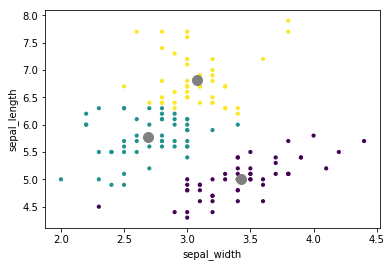

In [7]:
data = df[cols]
kmeans = KMeansFromScratch(k).fit(data)

fig, ax = plt.subplots()

p1 = data.plot.scatter(*cols, c="clusters", s=10, colormap='viridis', ax=ax, colorbar=False)
p2 = kmeans.centroids.plot.scatter(*cols, s=100, c="Gray", ax=ax, colorbar=False)

print(kmeans.n_iter)

We can use the elbow method to try to determine the best number of cluster, in case we didn't have prior knowledge about it.

/usr/lib/python3/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3/dist-packages/ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


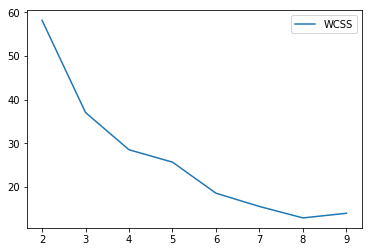

In [8]:
def show_wcss(KMeans, low=2, high=10):

    k_list = list(range(2,10))
    wcss_list = []

    for k in k_list:
        data = df[cols]
        wcss = KMeans(k).fit(data).inertia_
        wcss_list.append(wcss)

    p = pd.DataFrame(wcss_list, columns=["WCSS"], index=k_list).plot()
    
    return None


show_wcss(KMeansFromScratch)

# Compare with KMeans from sklearn

/usr/lib/python3/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


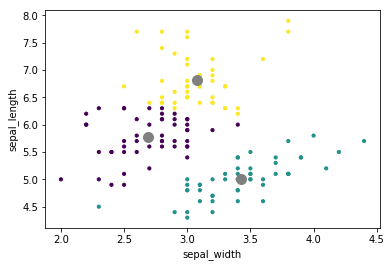

In [9]:
kmeans = KMeans(n_clusters=k)
kmeans.fit(data[cols])
data["clusters"] = kmeans.predict(df[cols])
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=cols)


fig, ax = plt.subplots()

p1 = data.plot.scatter(*cols, c="clusters", s=10, colormap='viridis', ax=ax, colorbar=False)
p2 = centroids.plot.scatter(*cols, s=100, c="Gray", ax=ax, colorbar=False)

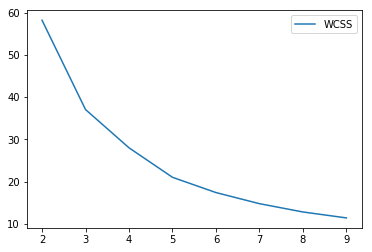

In [10]:
show_wcss(KMeans)

# Further reading

See [this](https://mubaris.com/2017/10/01/kmeans-clustering-in-python/) for an example in 3D using a random dataset.